# 0. Przygotowanie danych

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("results.csv")
teams_IEM = ['G2', 'fnatic', 'Natus Vincere', 'MAD Lions', '100 Thieves',
       'Astralis', 'Virtus.pro', 'Liquid', 'NiP', 'Vitality', 'Renegades',
       'mousesports', 'Evil Geniuses', 'FaZe', 'TYLOO', 'Cloud9']
maps = ['Cache','Cobblestone','Dust2','Inferno','Mirage','Nuke','Overpass','Train','Vertigo']
IEM_team_map = {'G2' : 1, 'fnatic' :2, 'Natus Vincere':3, 'MAD Lions':4, '100 Thieves':5,
       'Astralis':6, 'Virtus.pro':7, 'Liquid':8, 'NiP':9, 'Vitality':10, 'Renegades':11,
       'mousesports':12, 'Evil Geniuses':13, 'FaZe':14, 'TYLOO':15, 'Cloud9':16}
IEM_id = 4901
final_date = '2020-02-23'
IEM_df = df[(df['event_id'] == 4901)]

In [ ]:
#Usunięcie wszystkich meczów po rozpoczęciu IEM
df['date']= pd.to_datetime(df['date'])
df = df[(df['date'] < '2020-02-23')]

In [ ]:
df = df[(df['team_1'].isin(teams_IEM)) & (df['team_2'].isin(teams_IEM))]
df = df[df['_map'].isin(maps)]

In [ ]:
df = df.drop(['result_1', 'result_2', 'starting_ct', 'event_id', 'match_id', 'map_wins_1', 'map_wins_2', 'match_winner'], axis=1)

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df

,date,team_1,team_2,_map,map_winner,ct_1,t_2,t_1,ct_2,rank_1,rank_2
0,2020-02-15,100 Thieves,Evil Geniuses,Nuke,2,7,8,8,7,10,5
1,2020-02-15,100 Thieves,Evil Geniuses,Train,2,1,4,3,12,10,5
2,2020-02-14,100 Thieves,G2,Vertigo,2,8,7,4,9,10,8
3,2020-02-14,100 Thieves,G2,Dust2,2,8,7,5,9,10,8
4,2020-02-09,Natus Vincere,Vitality,Inferno,1,11,4,5,8,8,6
...,...,...,...,...,...,...,...,...,...,...,...
2353,2015-11-08,Virtus.pro,mousesports,Cobblestone,1,4,1,12,3,4,13
2354,2015-11-08,Virtus.pro,mousesports,Inferno,1,5,4,11,4,4,13
2355,2015-11-08,Virtus.pro,mousesports,Mirage,1,13,2,3,6,4,13
2356,2015-11-06,Natus Vincere,mousesports,Overpass,2,4,11,3,5,5,13


## 0.1 Ekstrakcja winrate-ów dla t i ct na poszczególnych mapach
### Źródło: https://www.kaggle.com/shakowski/cs-go-analysis

In [ ]:
ct_1 = df[['date','_map','ct_1']].rename(columns={'ct_1':'ct'})
ct_2 = df[['date','_map','ct_2']].rename(columns={'ct_2':'ct'})
ct = pd.concat((ct_1,ct_2))

In [ ]:
t_1 = df[['date','_map','t_1']].rename(columns={'t_1':'t'})
t_2 = df[['date','_map','t_2']].rename(columns={'t_2':'t'})
t = pd.concat((t_1,t_2))

In [ ]:
t = t.sort_values('date')
ct = ct.sort_values('date')

In [ ]:
series_t, series_ct, how_ct = {},{},{}
for i, key in enumerate(maps):
    t_map = t[t._map == maps[i]]
    ct_map = ct[ct._map == maps[i]]
    y_t = t_map.t.rolling(min_periods = 20, window= 200, center=True).sum().values
    y_ct = ct_map.ct.rolling(min_periods = 20, window= 200, center=True).sum().values
    
    series_t[key] = pd.Series(data=y_t,index=t_map.date)
    series_ct[key] = pd.Series(data=y_ct,index=ct_map.date)
    
    how_ct[key] = series_ct[key]/(series_ct[key]+series_t[key])//0.001/10

In [ ]:
how_ct["Cobblestone"]

date
2015-11-08    45.2
2015-11-08    45.5
2015-11-15    45.7
2015-11-15    45.3
2015-11-15    45.3
              ... 
2018-04-20    52.6
2018-04-25    52.4
2018-04-25    52.1
2018-04-26    51.7
2018-04-26    51.5
Length: 314, dtype: float64

In [ ]:
def add_trace(_map):
    fig.add_trace(go.Scatter(x=how_ct[_map].index, y=how_ct[_map].values, name=_map))

In [ ]:
fig = go.Figure()
for _map in maps:
    add_trace(_map)
fig.add_trace(go.Scatter(x=['2015-11-01', '2020-02-23'], y=[50,50],
                         mode='lines',line=dict(color='grey'),showlegend=False))
fig.update_layout(title='Distribution of rounds between CT and T sides',
                  yaxis_title='Percentage of round won on the CT-side (%)')
fig.show()

## 0.2 Stworzenie kolumny z przewagą danego zespołu na mapie

In [ ]:
df["better_team"] = ""

In [ ]:
for index, row in df.iterrows():
  if how_ct[df['_map'].iloc[index]].get(df['date'].iloc[index])[0] >= 50:
    df['better_team'].iloc[index] = "ct"
  else:
    df['better_team'].iloc[index] = "t"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df = df[::-1]
df = df.reset_index(drop=True)

In [ ]:
df["team_1_power"] = 0
df["team_2_power"] = 0
df["team_1_winrate"] = 0
df["team_2_winrate"] = 0

for team in teams_IEM:
  round_power = 0
  round_count = 0
  wins = 0
  loses = 0
  i = 0
  



  for index, row in df.iterrows():
    if i == 0:
      round_power = 30
      round_count = 30
      i += 1
      

    if df['team_1'].iloc[index] == team:
      df['team_1_power'].iloc[index] = round_power / round_count
      if loses == 0:
        df['team_1_winrate'].iloc[index] = 0
      else:
        df['team_1_winrate'].iloc[index] = wins/loses
      if df['better_team'].iloc[index] == "t":
        round_power += df['ct_1'].iloc[index]*2 + df['ct_2'].iloc[index]*0 + df['t_1'].iloc[index]*1.25 + df['t_2'].iloc[index]*0.75
        
      elif df['better_team'].iloc[index] == "ct":
        round_power += df['ct_1'].iloc[index]*1.25 + df['ct_2'].iloc[index]*0.75 + df['t_1'].iloc[index]*2 + df['t_2'].iloc[index]*0

      round_count += df['ct_1'].iloc[index] + df['ct_2'].iloc[index] + df['t_1'].iloc[index]+ df['t_2'].iloc[index]
      if df['map_winner'].iloc[index] == 1:
        wins += 1
      else:
        loses += 1

    elif df['team_2'].iloc[index] == team:
      df['team_2_power'].iloc[index] = round_power / round_count
      if loses == 0:
        df['team_2_winrate'].iloc[index] = 0
      else:
        df['team_2_winrate'].iloc[index] = wins/loses

      if df['better_team'].iloc[index] == "t":
        round_power += df['ct_1'].iloc[index]*0 + df['ct_2'].iloc[index]*2 + df['t_1'].iloc[index]*0.75 + df['t_2'].iloc[index]*1.25

      elif df['better_team'].iloc[index] == "ct":
        round_power += df['ct_1'].iloc[index]*0.75 + df['ct_2'].iloc[index]*1.25 + df['t_1'].iloc[index]*0 + df['t_2'].iloc[index]*2
      
      round_count += df['ct_1'].iloc[index] + df['ct_2'].iloc[index] + df['t_1'].iloc[index]+ df['t_2'].iloc[index]
      if df['map_winner'].iloc[index] == 2:
        wins += 1
      else:
        loses += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df

,date,team_1,team_2,_map,map_winner,ct_1,t_2,t_1,ct_2,rank_1,rank_2,better_team,team_1_power,team_2_power,team_1_winrate,team_2_winrate
0,2015-11-06,Natus Vincere,mousesports,Mirage,2,9,6,1,10,5,13,ct,1.000000,1.000000,0.000000,0.000000
1,2015-11-06,Natus Vincere,mousesports,Overpass,2,4,11,3,5,5,13,ct,0.906250,1.093750,0.000000,0.000000
2,2015-11-08,Virtus.pro,mousesports,Mirage,1,13,2,3,6,4,13,ct,1.000000,1.170886,0.000000,0.000000
3,2015-11-08,Virtus.pro,mousesports,Inferno,1,5,4,11,4,4,13,ct,1.050926,1.104369,0.000000,2.000000
4,2015-11-08,Virtus.pro,mousesports,Cobblestone,1,4,1,12,3,4,13,t,1.128205,1.027559,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2353,2020-02-09,Natus Vincere,Vitality,Inferno,1,11,4,5,8,8,6,ct,1.009603,1.014781,1.119318,1.044444
2354,2020-02-14,100 Thieves,G2,Dust2,2,8,7,5,9,10,8,t,0.887157,0.985173,0.363636,0.894737
2355,2020-02-14,100 Thieves,G2,Vertigo,2,8,7,4,9,10,8,t,0.891279,0.985345,0.333333,0.899123
2356,2020-02-15,100 Thieves,Evil Geniuses,Train,2,1,4,3,12,10,5,ct,0.894105,1.010923,0.307692,1.423077


In [ ]:
df.team_1 = df.team_1.replace(IEM_team_map)
df.team_2 = df.team_2.replace(IEM_team_map)

## 0.4. Dodanie tych samych meczy z zamienieniem team 1 z team 2

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy.team_1 = df.team_2
df_copy.team_2 = df.team_1

for index, row in df.iterrows():
  if(row.map_winner == 2):
    df_copy.map_winner[index] = 1
  else:
    df_copy.map_winner[index] = 2

df_copy.ct_1 = df.t_1
df_copy.t_1 = df.ct_1
df_copy.ct_2 = df.t_2
df_copy.t_2 = df.ct_2

df_copy.team_1_power = df.team_2_power
df_copy.team_2_power = df.team_1_power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
frames = [df, df_copy]
df = pd.concat(frames)
df = df.reset_index(drop=True)

## 0.5 Dodanie na próbę nowych kolumn rank_dif i pow_dif

In [ ]:
df["rank_dif"] = 0.0
df["pow_dif"] = 0.0

for index, row in df.iterrows():
  df.pow_dif[index] = row.team_1_power - row.team_2_power
  df.rank_dif[index] = row.rank_1 - row.rank_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df

,date,team_1,team_2,_map,map_winner,ct_1,t_2,t_1,ct_2,rank_1,rank_2,better_team,team_1_power,team_2_power,team_1_winrate,team_2_winrate,rank_dif,pow_dif
0,2015-11-06,3,12,Mirage,2,9,6,1,10,5,13,ct,1.000000,1.000000,0.000000,0.000000,-8.0,0.000000
1,2015-11-06,3,12,Overpass,2,4,11,3,5,5,13,ct,0.906250,1.093750,0.000000,0.000000,-8.0,-0.187500
2,2015-11-08,7,12,Mirage,1,13,2,3,6,4,13,ct,1.000000,1.170886,0.000000,0.000000,-9.0,-0.170886
3,2015-11-08,7,12,Inferno,1,5,4,11,4,4,13,ct,1.050926,1.104369,0.000000,2.000000,-9.0,-0.053443
4,2015-11-08,7,12,Cobblestone,1,4,1,12,3,4,13,t,1.128205,1.027559,0.000000,1.000000,-9.0,0.100646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4711,2020-02-09,10,3,Inferno,2,5,8,11,4,8,6,ct,1.014781,1.009603,1.119318,1.044444,2.0,0.005178
4712,2020-02-14,1,5,Dust2,1,5,9,8,7,10,8,t,0.985173,0.887157,0.363636,0.894737,2.0,0.098016
4713,2020-02-14,1,5,Vertigo,1,4,9,8,7,10,8,t,0.985345,0.891279,0.333333,0.899123,2.0,0.094066
4714,2020-02-15,13,5,Train,1,3,12,1,4,10,5,ct,1.010923,0.894105,0.307692,1.423077,5.0,0.116818


# 1. Wytrenowanie modeli

## 1.1. LogReg

In [ ]:
#split dataset in features and target variable
feature_cols = ['team_1', 'team_2', 'rank_dif', 'pow_dif']
X = df[feature_cols] # Features
y = df.map_winner # Target variable

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=4444)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)


y_pred=logreg.predict(X_test)

In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[343, 249],
       [286, 301]])

In [ ]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

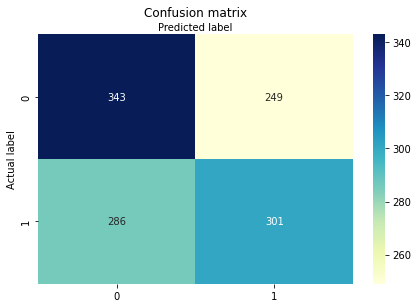

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.546225614927905
Precision: 0.5453100158982512
Recall: 0.5793918918918919


## 1.2. NN

In [ ]:
model = Sequential()
model.add(Dense(8, input_shape=(X_train.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

model.fit(X_train,
          y_train,
          callbacks=[es],
          epochs=40,
          batch_size=5,
          validation_split=0.1,
          shuffle=True,
          verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/40
637/637 [==============================] - 2s 2ms/step - loss: -129.6096 - accuracy: 0.5024 - val_loss: -573.7371 - val_accuracy: 0.4718
Epoch 2/40
637/637 [==============================] - 1s 2ms/step - loss: -2119.9326 - accuracy: 0.5024 - val_loss: -4760.6885 - val_accuracy: 0.4718
Epoch 3/40
637/637 [==============================] - 1s 2ms/step - loss: -8887.9883 - accuracy: 0.5024 - val_loss: -15106.5498 - val_accuracy: 0.4718
Epoch 4/40
637/637 [==============================] - 1s 2ms/step - loss: -22102.0176 - accuracy: 0.5024 - val_loss: -32664.8184 - val_accuracy: 0.4718
Epoch 5/40
637/637 [==============================] - 1s 2ms/step - loss: -42404.2344 - accuracy: 0.5024 - val_loss: -58021.3672 - val_accuracy: 0.4718
Epoch 6/40
637/637 [==============================] - 1s 2ms/step - loss: -70463.9766 - accuracy: 0.5024 - val_loss: -91760.5781 - val_accuracy: 0.4718
Epoch 7/40
637/637 [==============================] - 1s 2ms/step - loss: -106981.3750 - accura

# 3. PREDYKCJA WYNIKÓw

In [ ]:
print(logreg.predict([[1,3,-1,(0.98-1.009)]]))

[2]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names

